In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
import torch
import numpy as np
from multiprocessing import Pool
import scanpy as sc
from scipy.stats import ks_2samp
import pandas as pd
import random
from dataprep import *
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

sns.set_theme()

# Load data

In [3]:
path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced = pickle.load(p)

path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern_balanced_singlejob.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced_singlejob = pickle.load(p)

In [4]:
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [ ]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
choices = ['strong', 'intermediate', 'low']
for adata in [adata_split_cellID]:#, adata_mixed_cellID adata_all_spots]:
    conditions = [
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
    ]

    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [ ]:
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

In [ ]:
def map_interval(interval):
    if interval == '0-10':
        return '0-10'
    elif interval in ['10-20', '20-30']:
        return '10-30'
    elif interval in ['30-40', '40-50', '50-60']:
        return '30-60'
    elif interval in ['70-80', '80-90', '90-100']:
        return '70-100'
    elif interval == '100+':
        return '100+'
    else:
        return None

adata_test.obs['rna_count'] = adata_test.obs['n_spots_interval'].apply(map_interval)

<ipython-input-26-93478e804234>:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs['rna_count'] = adata_test.obs['n_spots_interval'].apply(map_interval)


In [65]:
for strength in adata_test.obs['pattern_strength'].unique():
    test = adata_test[(adata_test.obs['pattern_strength'] == strength) & (adata_test.obs['pattern'] == 'random')]
    print(strength)
    print(test.obs['rna_count'].value_counts())

strong
100+      5544
30-60     2568
70-100    2337
10-30     1870
0-10       413
Name: rna_count, dtype: int64
intermediate
100+      5344
30-60     2598
70-100    2567
10-30     1653
0-10       577
Name: rna_count, dtype: int64
low
100+      5325
30-60     2670
70-100    2498
10-30     1782
0-10       452
Name: rna_count, dtype: int64


# Functions

In [58]:
def subset_power_analysis(adata, pattern: str = 'random', mixed_patterns: bool = True, pattern_strength: str = "strong", rna_count: str = '10-30', sample_size: int = 5):
    """
    Subset the anndata object into a `1 gene multiple cells` object. Can filter the cells based on the number of spots, the pattern and the pattern strength.

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    pattern : str
        Type of subcellular expression pattern you want to filter on. Default is 'pericellular', which has the highest f1 RF score.
    mixed_patterns: bool
        True: all patterns can be included, False: only the pattern type specified in `pattern` is included. Default is False. 
    pattern_strength : str
        strength of the pattern, which is labeled as pattern_strength in the anndata object. Strong, which comes down to 45% of points fall in the pattern for protrusion, 90% of points are in pattern for all the other patterns. 
        If the pattern is random, then pattern_strength is not used, given that irrelevant for random when using the simFISH v2 definition of patterness (90% of points assigned to the pattern 'random' will still amount to 100% randomness).
    high_or_low : str
        Whether you want to filter genes with a higher or lower count than the given threshold. Default is lower.
        If none, then no threshold is chosen and mixed counts are included. 
    count_threshold : int
        Count threshold to filter on. Default is 11, so that genes with count 0-10 are selected. For high, the threshold is 140.
    mixed_counts: bool
        True: all counts are included, False: only counts above or below the threshold are included. Default is False.
        
    Returns
    -------
    ad.AnnData

    """
    adata_filtered = adata[(
                                (
                                    adata.obs['pattern'] == pattern if mixed_patterns == False
                                    else adata.obs['pattern'] != 'random'
                                )
                            ) & 
                           (
                                adata.obs['rna_count'] == rna_count
                            ) & 
                           (
                               adata.obs['pattern_strength'] == pattern_strength if pattern != 'random' 
                               else True
                            )
                        ].copy()

    subset = adata_filtered.obs.sample(n=sample_size)
    
    adata_subset = adata_filtered[adata_filtered.obs.index.isin(subset.index)]


    return adata_subset

In [75]:
def subset_power_analysis_unique_CellIDs(adata, pattern: str = 'pericellular', mixed_patterns: bool = True, pattern_strength: str = "strong", rna_count: str = '10-30', sample_size: int = 5):
    """
    Subset the anndata object into a `1 gene multiple cells` object. Can filter the cells based on the number of spots, the pattern and the pattern strength.

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    pattern : str
        Type of subcellular expression pattern you want to filter on. Default is 'pericellular', which has the highest f1 RF score.
    mixed_patterns: bool
        True: all patterns can be included, False: only the pattern type specified in `pattern` is included. Default is False. 
    pattern_strength : str
        strength of the pattern, which is labeled as pattern_strength in the anndata object. Strong, which comes down to 45% of points fall in the pattern for protrusion, 90% of points are in pattern for all the other patterns. 
        If the pattern is random, then pattern_strength is not used, given that irrelevant for random when using the simFISH v2 definition of patterness (90% of points assigned to the pattern 'random' will still amount to 100% randomness).
    high_or_low : str
        Whether you want to filter genes with a higher or lower count than the given threshold. Default is lower.
        If none, then no threshold is chosen and mixed counts are included. 
    count_threshold : int
        Count threshold to filter on. Default is 11, so that genes with count 0-10 are selected. For high, the threshold is 140.
    mixed_counts: bool
        True: all counts are included, False: only counts above or below the threshold are included. Default is False.
        
    Returns
    -------
    ad.AnnData

    """
    adata_filtered = adata[(
                                (
                                    adata.obs['pattern'] == pattern if mixed_patterns == False
                                    else adata.obs['pattern'] != 'random'
                                )
                            ) & 
                           (
                                adata.obs['rna_count'] == rna_count
                            ) & 
                           (
                               adata.obs['pattern_strength'] == pattern_strength if pattern != 'random' 
                               else True
                            )
                        ].copy()
    
    if sample_size > len(adata_filtered.obs['cell_id'].unique()):
        return(f"{sample_size} is larger than the available unique cell id's.")

    grouped = adata_filtered.obs.groupby('cell_id')
    subset = grouped.sample(n=1).groupby('cell_id').apply(lambda x: x.sample(min(len(x), sample_size)))
    adata_subset = adata_filtered[adata_filtered.obs.index.isin(subset.index)].copy()

    return adata_subset

In [ ]:
'''def subset_power_analysis_unique_CellIDs(adata, pattern: str = 'pericellular', mixed_patterns: bool = True, pattern_strength: str = "strong", rna_count: str = '10-30', sample_size: int = 5):
    """
    
    """
    adata_filtered = adata[(
                                (
                                    adata.obs['pattern'] == pattern if mixed_patterns == False
                                    else adata.obs['pattern'] != 'random'
                                )
                            ) & 
                           (
                                adata.obs['rna_count'] == rna_count
                            ) & 
                           (
                               adata.obs['pattern_strength'] == pattern_strength if pattern != 'random' 
                               else True
                            )
                        ].copy()
    
    if sample_size > len(adata_filtered.obs['cell_id'].unique())
        return(f"{sample_size} is larger than the available unique cell id's.")

    grouped = adata_filtered.obs.groupby('cell_id')
    subset = [group.sample(n=1) for _, group in grouped]
    adata_subset = adata_filtered[adata_filtered.obs.index.isin(subset.index)].copy()

    return adata_subset
    '''

subsample mixed patterns -> no seed
add extra column to anndata for the different n_spots_intervals I'm interested in
create grid over sample size 5-3000


First go and make the inner loop, then I can build outwards.

Add bins to pool the power calculation for n_spots_interval

In [68]:
def compute_power(params):
    try:
        strength, count, sample = params
        significant_count = 0
        # Given that random patterns have only ~410 cells simulated, we don't calculate the power for these above 400 so that we don't need to sample with replacement
        if count == '0-10' and sample > 400:
            return (f'{strength}_{count}_{sample}', -1)
        for i in range(1000):
            # sample new gene. No random seed so that every time a different "gene" is sampled.
            pattern = subset_power_analysis(adata_test, mixed_patterns = True, pattern_strength= strength, rna_count = count, sample_size = sample)
            control = subset_power_analysis(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample)

            # Calculate RF classification probabilities
            pattern_score = rf_pattern_balanced_singlejob.predict_proba(pattern.obsm["latent"])[:,1]
            control_score = rf_pattern_balanced_singlejob.predict_proba(control.obsm["latent"])[:,1]

            statistic, pvalue = ks_2samp(pattern_score, control_score)
            if pvalue < 0.05:
                significant_count += 1
        return (f'{strength}_{count}_{sample}', significant_count/1000)
    except ValueError as e:
        if str(e) == "Cannot take a larger sample than population when 'replace=False'":
            print(f"Error for parameters: {params}")
            return None
        else:
            raise e

# Power analysis

In [49]:
import numpy as np

# Generate 10 points between 5 and 3000 on a log scale
points = np.logspace(np.log10(10), np.log10(1500), num=15)

# Round the points to the nearest integers
points = np.round(points).astype(int)

print(points)

[  10   14   20   29   42   60   86  122  175  251  358  513  733 1049
 1500]


In [ ]:
strengths = ['strong', 'intermediate', 'low']
counts = adata_test.obs['rna_count'].unique()
samples = [10, 14, 20, 29, 42, 60, 86, 122, 175, 251, 358, 513, 733, 1049, 1500] # 15 rounded points between 10 and 1500 on a log10 scale

# Create a list of all combinations of strength, count, and sample
combinations = [(strength, count, sample) for strength in strengths for count in counts for sample in samples]

# Create a multiprocessing pool and compute the power for each combination
with Pool(45) as p:
    results = p.map(compute_power, combinations)

# Convert the results to a dictionary
power_results = dict(results)

### TO DO: the power analysis with split ID here

In [73]:
def compute_power_splitID(params):
    try:
        strength, count, sample = params
        significant_count = 0
        # Given that random patterns have only ~410 cells simulated, we don't calculate the power for these above 400 so that we don't need to sample with replacement
        if count == '0-10' and sample > 400:
            return (f'{strength}_{count}_{sample}', -1)
        for i in range(1000):
            # sample new gene. No random seed so that every time a different "gene" is sampled.
            pattern = subset_power_analysis_unique_CellIDs(adata_test, mixed_patterns = True, pattern_strength= strength, rna_count = count, sample_size = sample)
            control = subset_power_analysis_unique_CellIDs(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample)

            # Calculate RF classification probabilities
            pattern_score = rf_pattern_balanced_singlejob.predict_proba(pattern.obsm["latent"])[:,1]
            control_score = rf_pattern_balanced_singlejob.predict_proba(control.obsm["latent"])[:,1]

            statistic, pvalue = ks_2samp(pattern_score, control_score)
            if pvalue < 0.05:
                significant_count += 1
        return (f'{strength}_{count}_{sample}', significant_count/1000)
    except ValueError as e:
        if str(e) == "Cannot take a larger sample than population when 'replace=False'":
            print(f"Error for parameters: {params}")
            return None
        else:
            raise e

In [71]:
adata_test.obs['cell_id'].unique()

['106', '136', '294', '182', '27', ..., '84', '9', '34', '57', '38']
Length: 64
Categories (64, object): ['6', '9', '10', '15', ..., '294', '297', '303', '314']

In [77]:
strengths = ['strong', 'intermediate', 'low']
counts = adata_test.obs['rna_count'].unique()
samples = [5,15,25,35,45,55,64] # 15 rounded points between 10 and 1500 on a log10 scale

# Create a list of all combinations of strength, count, and sample
combinations = [(strength, count, sample) for strength in strengths for count in counts for sample in samples]

# Create a multiprocessing pool and compute the power for each combination
with Pool(45) as p:
    results = p.map(compute_power_splitID, combinations)

# Convert the results to a dictionary
power_results = dict(results)

### Safe and load power analysis dictionary

In [ ]:
path = f"temp_objects/power_analysis_upto1500.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(power_results, f)

In [ ]:
path = f"temp_objects/power_analysis.pkl"

with open(path, 'rb') as p:
    power_results = pickle.load(p)

### Visualizations

In [6]:
# Convert the dictionary to a list of tuples
data = [(strength, rna_count, sample_size, power) for key, power in power_results.items() for strength, rna_count, sample_size in [key.split('_')]]

# Convert the list of tuples to a DataFrame
df = pd.DataFrame(data, columns=["strength", "rna_count", "sample_size", "power"])

In [12]:
# Replace values in the 'strength' column --> so I can have a capital in my plot titles
df['strength'] = df['strength'].replace({'strong': 'Strong', 'intermediate': 'Intermediate', 'low': 'Low'})

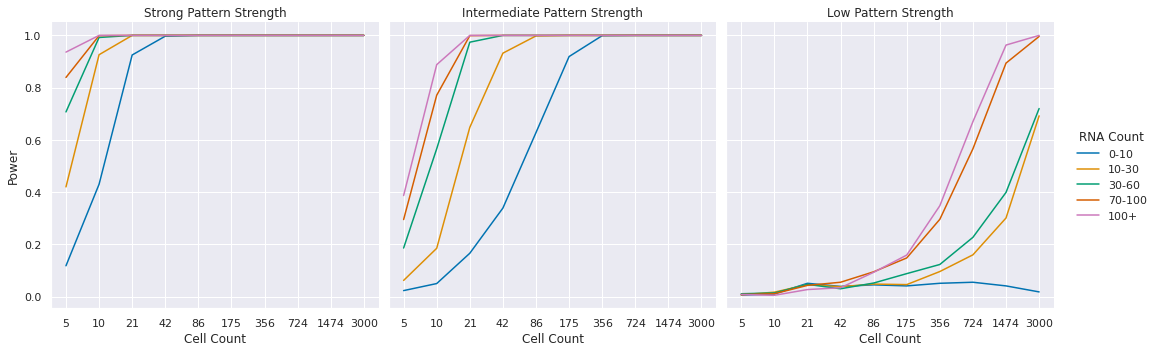

In [22]:
# Create three plots with different pattern strengths
g = sns.relplot(
    data=df, 
    x="sample_size", 
    y="power", 
    hue="rna_count",
    hue_order = ['0-10', '10-30', '30-60', '70-100','100+'],
    palette="colorblind",
    col="strength",
    kind="line")
(g
  .set_axis_labels("Cell Count", "Power")
  .set_titles("{col_name} Pattern Strength")
  .tight_layout(w_pad=1)
  .legend.set_title("RNA Count"))
# Show the plot
plt.show()